<a href="https://colab.research.google.com/github/bartolomeoadrian/computer-vision/blob/main/08_fast_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Cargar librerías

In [10]:
import os, random, time, numpy as np, matplotlib.pyplot as plt
import requests, cv2
import torch, torchvision
from torchvision.transforms import functional as F
from torchvision.ops import box_iou
from torchvision.datasets import OxfordIIITPet
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image, ImageDraw, ImageFont

SEED=42; random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEV)

Device: cpu


# 2 - Cargar y normalizar imágenes

In [4]:
def _bbox_from_mask(mask):
    y,x = np.where(mask>0)
    if len(x)==0: return None
    return [float(x.min()), float(y.min()), float(x.max()), float(y.max())]

class PetsDet(torch.utils.data.Dataset):
    def __init__(self, root="./data", split="trainval", short=224, download=True):
        self.base = OxfordIIITPet(root=root, split=split, target_types="segmentation", download=download)
        self.short = short
    def __len__(self): return len(self.base)
    def __getitem__(self, i):
        img, m = self.base[i]
        m = (np.array(m)>0).astype(np.uint8)
        bb = _bbox_from_mask(m)
        if bb is None:
            w,h = img.size; bb=[0,0,w-1,h-1]
        w,h = img.size
        if min(w,h)!=self.short:
            if w<h: nw,nh=self.short,int(round(h*self.short/w))
            else:   nh,nw=self.short,int(round(w*self.short/h))
            sx,sy=nw/w, nh/h
            img = img.resize((nw,nh), Image.BILINEAR)
            x1,y1,x2,y2=bb; bb=[x1*sx,y1*sy,x2*sx,y2*sy]
        img = F.to_tensor(img).float()
        tgt={"boxes":torch.tensor([bb],dtype=torch.float32),"labels":torch.tensor([1],dtype=torch.int64)}
        return img,tgt

ds_all = PetsDet(short=224)
N=len(ds_all); idx=torch.randperm(N).tolist()
N_TRAIN=min(400,int(0.85*N)); N_VAL=min(100,N-N_TRAIN)
train_ds=torch.utils.data.Subset(ds_all, idx[:N_TRAIN])
val_ds  =torch.utils.data.Subset(ds_all, idx[N_TRAIN:N_TRAIN+N_VAL])

def collate(b):
    x,y=list(zip(*b)); return list(x),list(y)
train_dl=torch.utils.data.DataLoader(train_ds,batch_size=2,shuffle=True,collate_fn=collate,num_workers=2,pin_memory=True)
val_dl  =torch.utils.data.DataLoader(val_ds,  batch_size=2,shuffle=False,collate_fn=collate,num_workers=2,pin_memory=True)
print(f"Train {len(train_ds)} | Val {len(val_ds)} | Batches: {len(train_dl)}/{len(val_dl)}")


100%|██████████| 792M/792M [00:24<00:00, 32.7MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 16.4MB/s]


Train 400 | Val 100 | Batches: 200/50


# 3 - Definir una red neuronal

In [5]:
try:
    from torchvision.models.detection import FasterRCNN_MobileNet_V3_Large_FPN_Weights
    weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
except: weights="DEFAULT"

model=fasterrcnn_mobilenet_v3_large_fpn(weights=weights)
in_feats=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor=FastRCNNPredictor(in_feats,2)

for p in model.backbone.parameters(): p.requires_grad=False
for a,v in dict(
    pre_nms_top_n_train=50, pre_nms_top_n_test=50,
    post_nms_top_n_train=50, post_nms_top_n_test=50,
    batch_size_per_image=32
).items():
    if hasattr(model.rpn,a): setattr(model.rpn,a,v)
model.roi_heads.batch_size_per_image=64

model=model.to(DEV)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


100%|██████████| 74.2M/74.2M [00:01<00:00, 63.8MB/s]


# 4 - Definir una función de pérdida y un optimizador

In [6]:
opt=torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.01, momentum=0.9, weight_decay=5e-4)
sch=torch.optim.lr_scheduler.StepLR(opt, step_size=2, gamma=0.1)
use_amp = (DEV.type=="cuda"); scaler=torch.cuda.amp.GradScaler(enabled=use_amp)

/tmp/ipython-input-1272358919.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  use_amp = (DEV.type=="cuda"); scaler=torch.cuda.amp.GradScaler(enabled=use_amp)


# 5 - Entrenar a la red

In [7]:
def train_one_epoch():
    model.train(); acc=0.0
    for imgs, tgts in train_dl:
        imgs=[x.to(DEV) for x in imgs]; tgts=[{k:v.to(DEV) for k,v in t.items()} for t in tgts]
        opt.zero_grad(set_to_none=True)
        if use_amp:
            with torch.cuda.amp.autocast():
                ld=model(imgs,tgts); loss=sum(ld.values())
            scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        else:
            ld=model(imgs,tgts); loss=sum(ld.values()); loss.backward(); opt.step()
        acc+=float(loss.item())
    return acc/len(train_dl)

EPOCHS=1
for e in range(1,EPOCHS+1):
    t=time.time(); l=train_one_epoch(); sch.step()
    print(f"Epoch {e}/{EPOCHS} - loss {l:.4f} - {time.time()-t:.1f}s")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/1 - loss 0.3093 - 657.7s


# 6 - Prueba de la red

In [8]:
def eval_iou(th=0.5, iou_th=0.5):
    model.eval(); tp=fp=fn=0
    for imgs,tgts in val_dl:
        imgs=[x.to(DEV) for x in imgs]; outs=model(imgs)
        for o,t in zip(outs,tgts):
            keep=(o["scores"].detach().cpu().numpy()>=th)
            pb=o["boxes"][keep].cpu(); tb=t["boxes"].cpu()
            if len(pb)==0 and len(tb)>0: fn+=len(tb); continue
            if len(pb)>0 and len(tb)==0: fp+=len(pb); continue
            if len(pb)==0 and len(tb)==0: continue
            i=box_iou(pb,tb); matched=set()
            for r in range(len(pb)):
                j=int(i[r].argmax())
                if i[r,j]>=iou_th and j not in matched: matched.add(j)
                else: fp+=1
            tp+=len(matched); fn+=len(tb)-len(matched)
    P=tp/(tp+fp) if tp+fp>0 else 0; R=tp/(tp+fn) if tp+fn>0 else 0
    F=2*P*R/(P+R) if P+R>0 else 0
    return {"tp":tp,"fp":fp,"fn":fn,"precision":P,"recall":R,"f1":F}
print("Val:", eval_iou())

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Val: {'tp': 100, 'fp': 2, 'fn': 0, 'precision': 0.9803921568627451, 'recall': 1.0, 'f1': 0.99009900990099}


# 7 - Predicción

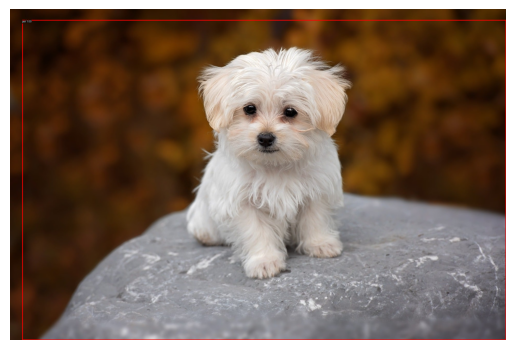

In [21]:
image_url = "https://www.aon.es/personales/seguro-perro-gato/wp-content/uploads/sites/2/2021/04/bichon-maltes.jpg"
response = requests.get(image_url)
with open("sample.jpg", "wb") as f:
    f.write(response.content)

img = cv2.imread("sample.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_tensor = F.to_tensor(img_rgb).unsqueeze(0).to(DEV)

model.eval()
with torch.no_grad():
    pred = model(img_tensor)[0]

score_thr = 0.5
boxes = pred["boxes"].cpu().numpy()
scores = pred["scores"].cpu().numpy()
labels = pred["labels"].cpu().numpy()

keep = scores >= score_thr

im = Image.fromarray(img_rgb)
draw = ImageDraw.Draw(im)
font = ImageFont.load_default()

for box, score, lab in zip(boxes[keep], scores[keep], labels[keep]):
    x1,y1,x2,y2 = box
    draw.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=3)
    draw.text((x1,y1), f"pet {score:.2f}", fill=(255,255,255), font=font,
              stroke_width=2, stroke_fill=(0,0,0))

plt.imshow(im)
plt.axis("off")
plt.show()